In [1]:
import tensorflow as tf
from model import Model
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [48]:
model_dir = 'keep_prob-1.0_output_layer-64_64_rnn_cell-gru_rnn_layer-64_64_test_site-Site_26_trn_site-Site_5'

In [49]:
trn_site = re.search('trn_site-([A-Za-z]+_\d+)', model_dir).group(1)
test_site = re.search('test_site-([A-Za-z]+_\d+)', model_dir).group(1)
rnn_cell = re.search('rnn_cell-([a-z]+)', model_dir).group(1)
rnn_layer = [int(x) for x in re.search('rnn_layer-((\d+?_)+)', model_dir).group(1).split('_')[:-1]]
output_layer = [int(x) for x in re.search('output_layer-((\d+?_)+)', model_dir).group(1).split('_')[:-1]]
keep_prob = float(re.search('keep_prob-(\d+\.\d+)', model_dir).group(1))

In [50]:
model_config = {'trn_site': trn_site,
                'test_site': test_site,
                'rnn_cell': rnn_cell,
                'rnn_layer': rnn_layer,
                'output_layer': output_layer,
                'keep_prob': keep_prob
                }

In [51]:
def get_inputs(data_type):
    data = np.load('data/{}/data.npz'.format(data_type))

    X = data['X'].astype(np.float32)

    y = np.expand_dims(data['y'].astype(np.float32), 1)
    return X, y

In [52]:
trn_inputs, trn_targets = get_inputs(trn_site)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Site_5/data.npz'

In [53]:
test_inputs, test_targets = get_inputs(test_site)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Site_26/data.npz'

In [8]:
inputs = tf.placeholder(tf.float32, [None, 5, 9])
targets = tf.placeholder(tf.float32, [None, 1, 2])

In [9]:
with tf.variable_scope('Model'):
    with tf.name_scope('Train'):    
        data_inputs = {'inputs' : inputs, 'targets' : targets}
        model = Model(data_inputs, rnn_cell, rnn_layer, output_layer, keep_prob)

In [10]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [11]:
saver = tf.train.Saver()

In [12]:
latest_ckpt = tf.train.latest_checkpoint('model/{}'.format(model_dir))

In [14]:
latest_ckpt

'model/keep_prob-1.0_output_layer-64_64_rnn_cell-gru_rnn_layer-64_64_test_site-Site_25_trn_site-Site_24/model.ckpt-6'

In [16]:
saver.restore(sess, latest_ckpt)

INFO:tensorflow:Restoring parameters from model/keep_prob-1.0_output_layer-64_64_rnn_cell-gru_rnn_layer-64_64_test_site-Site_25_trn_site-Site_24/model.ckpt-6


In [17]:
pred = sess.run(model.pred, feed_dict={inputs:test_inputs})

In [18]:
pred_trn = sess.run(model.pred, feed_dict={inputs:trn_inputs})

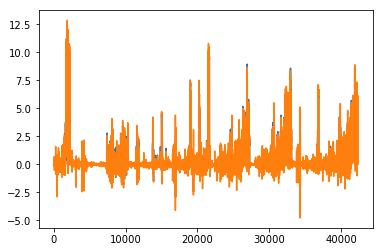

In [19]:
plt.plot(np.arange(len(pred_trn)), pred_trn[:, 0, 1])
plt.plot(np.arange(len(pred_trn)), trn_targets[:, 0, 1])

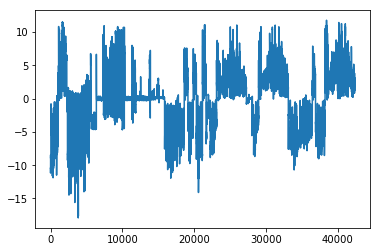

In [46]:
plt.plot(np.arange(len(pred_trn)), pred_trn[:, 0, 0])

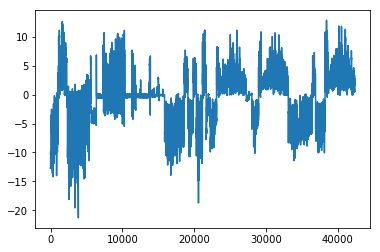

In [47]:
plt.plot(np.arange(len(pred_trn)), trn_targets[:, 0, 0])

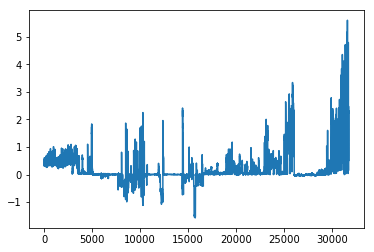

In [44]:
plt.plot(np.arange(len(pred)), pred[:, 0, 1])

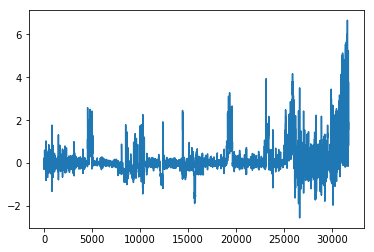

In [45]:
plt.plot(np.arange(len(pred)), test_targets[:, 0, 1])

In [24]:
trn_inputs.shape

(42375, 5, 9)

In [25]:
trn_site

'Site_24'

In [32]:
def plot_range(pred, target, range_value, target_variable):
    if target_variable == 's':
        target_col = 0
    elif target_variable == 'l':
        target_col = 1
    plt.plot(range_value, pred[range_value, 0, target_col])
    plt.plot(range_value, test_targets[range_value, 0, target_col])    

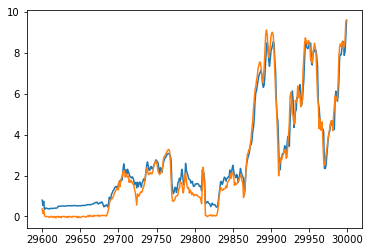

In [37]:
plot_range(pred, test_targets, np.arange(29600, 30000), 's')

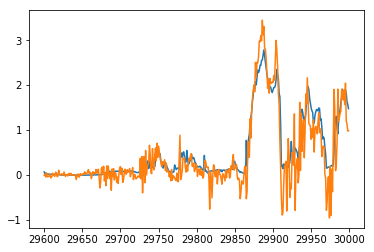

In [36]:
plot_range(pred, test_targets, np.arange(29600, 30000), 'l')

In [40]:
[x.name for x in tf.trainable_variables() if 'cell_0' in x.name and 'kernel' in x.name]

['Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/multi_rnn_cell/cell_0/gru_cell/candidate/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/multi_rnn_cell/cell_1/gru_cell/gates/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/multi_rnn_cell/cell_1/gru_cell/candidate/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/multi_rnn_cell/cell_0/gru_cell/candidate/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/multi_rnn_cell/cell_1/gru_cell/gates/kernel:0',
 'Model/load_s/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/multi_rnn_cell/cell_1/gru_cell/candidate/kernel:0',
 'Model/load_l/stack_bidirectional_rnn/cell_0/bidirectional_rnn/

In [ ]:
def mape_loss(pred, target, threshold):
    mask = np.abs(target) > threshold
    print(len(pred), sum(mask))
    target = target[mask]
    pred = pred[mask]
    loss = np.mean(np.abs(pred - target) / np.abs(target))
    return loss